<a href="https://colab.research.google.com/github/Ebadi-Fereshteh/Deep-Learning/blob/main/45-SheykhDetector-VGG16/45_SheykhDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wandb

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import wandb
from wandb.keras import WandbCallback
import cv2
import numpy as np
from tensorflow import keras
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.models import load_model

# Config wandb

In [108]:
wandb.init(project= "SheykhDetector")

In [10]:
config = wandb.config
config.learning_rate = 0.0001

# Dataset

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
train_dataset_path = "/content/drive/MyDrive/datasets/SheykhDetector/Train"
width = height = 224
batch_size= 32

idg = ImageDataGenerator(
    rotation_range= 10, 
    brightness_range= (0.8, 1.2), 
    shear_range=0.1, 
    zoom_range=0.1,
    horizontal_flip=True, 
    rescale= 1/255, 
    validation_split=0.2   
)

train_data = idg.flow_from_directory(
    train_dataset_path,
    target_size = (width, height),
    batch_size = batch_size,
    class_mode = "categorical",
    subset = "training"    

)

validation_data = idg.flow_from_directory(
    train_dataset_path,
    target_size = (width, height),
    batch_size = batch_size,
    class_mode = "categorical",
    subset = "validation"
)

Found 270 images belonging to 2 classes.
Found 66 images belonging to 2 classes.


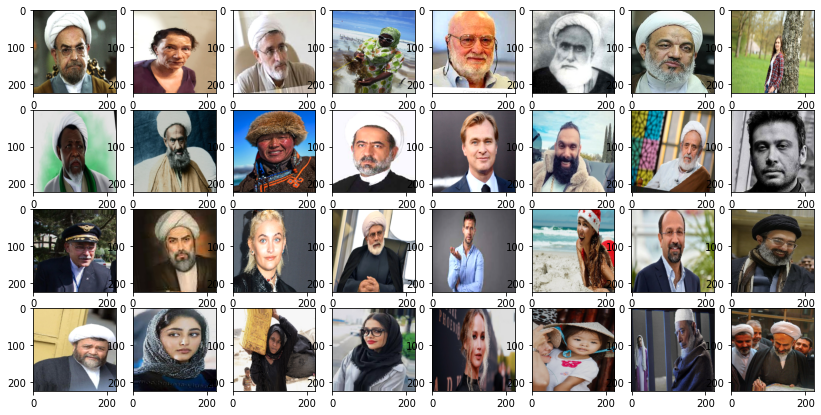

In [13]:
some_images = next(train_data)
X=some_images[0]
Y=some_images[1]

plt.figure(figsize=(14,7))
for i in range(32):
  plt.subplot(4,8,i+1)
  plt.imshow(X[i])

# Model

In [14]:
# customize base model
base_model = tf.keras.applications.VGG16(
    include_top = False,
    input_shape = (width, height, 3),
    weights = "imagenet",
    pooling="avg"
)



58900480/58889256 [==============================] - 1s 0us/step


In [15]:
# freez Layer
for layer in base_model.layers[:-4]:
    layer.trainable = False


In [16]:
model = tf.keras.models.Sequential([
    base_model,
    Flatten(),
    # Dense(512, activation='relu'),
    # Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    # Dense(64, activation='relu'),
    # Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

In [17]:
model.compile( optimizer= tf.keras.optimizers.Adam(learning_rate= config.learning_rate), 
              loss = tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [18]:
class CustomCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
        print("End epoch {} of training;".format(epoch))
        ep = "epoch_{}".format(epoch)
        dir = "/content/drive/MyDrive/models/SheykhDetector"
        name = "{}_{}.h5".format(dir, ep)
        print(name)
        model.save(name)

# Train

In [19]:
model_history = model.fit(train_data, validation_data= validation_data, epochs= 30, callbacks=[CustomCallback(), WandbCallback()])

Epoch 1/30
9/9 [==============================] - ETA: 0s - loss: 0.6897 - accuracy: 0.5185End epoch 0 of training;
/content/drive/MyDrive/models/SheykhDetector_epoch_0.h5
9/9 [==============================] - 144s 14s/step - loss: 0.6897 - accuracy: 0.5185 - val_loss: 0.5773 - val_accuracy: 0.6515 - _timestamp: 1649102444.0000 - _runtime: 187.0000
Epoch 2/30
9/9 [==============================] - ETA: 0s - loss: 0.5271 - accuracy: 0.7630End epoch 1 of training;
/content/drive/MyDrive/models/SheykhDetector_epoch_1.h5
9/9 [==============================] - 11s 1s/step - loss: 0.5271 - accuracy: 0.7630 - val_loss: 0.3929 - val_accuracy: 0.8636 - _timestamp: 1649102454.0000 - _runtime: 197.0000
Epoch 3/30
9/9 [==============================] - ETA: 0s - loss: 0.3566 - accuracy: 0.8852End epoch 2 of training;
/content/drive/MyDrive/models/SheykhDetector_epoch_2.h5
9/9 [==============================] - 10s 1s/step - loss: 0.3566 - accuracy: 0.8852 - val_loss: 0.2637 - val_accuracy: 0.9091

In [20]:
model.save('/content/drive/MyDrive/models/SheykhDetector.h5')

In [89]:
model = load_model('/content/drive/MyDrive/models/SheykhDetector_epoch_16.h5')

# Test


In [102]:
test_dataset_path = "/content/drive/MyDrive/datasets/SheykhDetector/Test"

width = height = 224
batchSize = 32

idg = ImageDataGenerator(
    rescale = 1/255
)

test_data = idg.flow_from_directory(
    test_dataset_path,
    target_size = (width, height),
    class_mode = "categorical",
    batch_size=batch_size,
)

Found 54 images belonging to 2 classes.


In [103]:
test_loss, test_acc= model.evaluate(test_data)
print(test_loss)
print(test_acc)

2/2 [==============================] - 3s 2s/step - loss: 0.0882 - accuracy: 0.9815
0.0882221981883049
0.9814814925193787


# Confusion matrix

[[26  0]
 [ 1 27]]


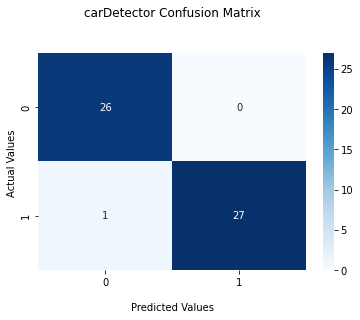

In [107]:
Y_pred = []

for path in test_data.filepaths:
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (width, height))
    image = image / 255
    image = image.reshape(1, width, height, 3)
    Y_pred.append(np.argmax(model.predict(image)))

cv_confMTX = confusion_matrix(test_data.classes, Y_pred)
print(cv_confMTX)

ax = sns.heatmap(cv_confMTX, annot=True, cmap='Blues')
ax.set_title('carDetector Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

plt.show()

# Inference

In [106]:
image_path = "/content/drive/MyDrive/datasets/Inference/SheykhRecognition/trump_01.png"

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # cv2 image color format !# tensorflow image color format
image = cv2.resize(image, (width, height))
image = image / 255
image = image.reshape(1, width, height, 3)
result = model.predict(image)
print(result)
pred = np.argmax(result)
print(pred)

if(pred == 0):
  print("Normal 👨 / 👩")
elif(pred == 1):
  print("Sheykh 👳")

[[9.9996066e-01 3.9362552e-05]]
0
Normal 👨 / 👩
